<h1> <font color='brown'>COMP41680 Assignment 2: Text Scraping & Classification</font></h1>


<h2><font color='brown'>Radhika Joshi 17202769</font></h2>

<hr style="height:2px">

<h2 align="center">  <font color='green'> Part 1. Data Collection</font> </h2>

<h3>  Collect a labelled news corpus</h3>
<ol>
    <li> Identifying the URL and Category Labels</li>
    We work for this part by following the steps mentioned below:
    <ol>
        <li> We work with the following website:http://mlg.ucd.ie/modules/COMP41680/archive/index.html </li>
        <li> From the website we can see that the website has archives of news articles. These articles are __categorised by month__, and within months, each news article is categorised into __three__ news categories based on the genre they cover :             </li>
               <ul>
                   <li>Technology</li>
                   <li>Business</li>
                   <li>Sport</li>
               </ul>
        <li>There are also some articles that are no longer available in this list.
    </ol>
    <li> If we inspect the URL for the articles we can observe a pattern in the URL. The home page lists the articles by month, and navigating to each of these months they URL changes to : http://mlg.ucd.ie/modules/COMP41680/archive/month_name_2017.html 
where name is all months from January to December. </li>
    <li> Next, for the article itself, the pattern is as follows : http://mlg.ucd.ie/modules/COMP41680/archive/article_month_reference_number.html where the month and(or) reference number change for each article. </li>
</ol>


We exploit this pattern to navigate and parse the pages. The body of each article is stored in one text file, and the category list is stored as a separate file.

<hr hr style="height:2px">

In [4]:
# import the packages "request" and "Beautiful Soup" for navigating and parsing the webpage.

from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq 

# Part of the link which is same for all the webpages
my_url = 'http://mlg.ucd.ie/modules/COMP41680/archive/'

# end of the main page of URL
main_page = 'index.html'

# initialising empty lists which will contain the following information :
container = list()            # this list will enlist all the links to months
article_list = list()         # this list contains all the article links
category_list = list()        # this contains all the categories listed per article in the form of a list

# define a function to navigate and parse the webpage for link to each page

def month_list():
    step = uReq(my_url+main_page)
    page_html = step.read()
    step.close()
    soups = soup(page_html,'html.parser')
        
    for div in soups.find_all('li'):
        container.append(div.a.get('href'))
        
month_list()
#print(container)
print('Month links collection complete')

Month links collection complete


Utilizing the function above, we get the links for navigating another page by the referenced month. Using this list in the "container", we iterate for each link and look for the article links and data to store it into different files. 

In [5]:
# loop to iterate and parse for all the links to the article pages.

for art in container:
    link = uReq(my_url+art)
    article=link.read()
    link.close()
    Soup = soup(article,'html.parser')
    #print(article)
    
    '''
    loop to find all the tr tags in the table to look for the category label. This will be used to assemble all the category
    labels in a file (data frame)
    
    '''
    for divtwo in Soup.find_all('tr'):
        divthree = divtwo.find("td",{'class':'category'})
        
        # Check if divthree = TRUE to ensure that only "td" with class=category are picked.
        if divthree:
            category = divthree.text
            category = category.strip()
            
            # Check for empty category, i.e. for any article which is no longer available in the archives
            if category != 'N/A':
                category_list.append(category)
        
        # add all class= title and also check if they have the "a" tag. For all elements that follow this, 
        # save the links obtained in "href" to the list "article_list"
        divfour = divtwo.find("td",{'class':'title'})
        
        if divfour and divfour.a :
            article_list.append(divfour.a.get('href'))

# Create dictionary with keys = article_list and value = category list which will store the article links 
# and the category labels together.            
dic = dict(zip(article_list, category_list))
print("Dictionary with links and category created")

Dictionary with links and category created


In [6]:
# Create data frame using the dictionary created above 

import pandas as pd
file1 = pd.DataFrame.from_dict(list(dic.items()))
file1.rename(columns={0: 'Link', 1: 'Category'}, inplace=True)
display(file1.head())


,Link,Category
0,article-jan-0418.html,technology
1,article-jan-0027.html,business
2,article-jan-0631.html,technology
3,article-jan-2105.html,business
4,article-jan-3300.html,sport


Created two files __'articles.txt'__  and  __'category_list.txt'__ to store the data scraped from the website. The file "articles.txt" contains each article and it's title as a single line of the text file. According to the data we see, we should have 1407 articles in this exercise.

The file "category_list" contains the link to each article and its class listed from the corpus. 

In [11]:
# create the two files to store data

f_file = open("articles.txt", 'a', encoding='utf-8')

for article_link in dic.keys():
    data = uReq(my_url+article_link)
    news=data.read()
    data.close()
    
    news_text = soup(news,'html.parser')
    
      
    article_body = news_text.find('body')
    header = article_body.find('h2').text
    f_file.write(header)
    f_file.write(" ")
    
    for p_text in article_body.find_all('p', class_=False):
        if len(p_text) > 0:
            f_file.write(p_text.text)
            f_file.write(" ")
    # Ensures each article is written in a newline
    f_file.write("\n")
        
f_file.close()
print('Writing to text file "articles" complete')

Writing to text file "articles" complete


In [12]:
# Write the category list file
import os
ff_file = open('category_list.txt', 'w', encoding='utf-8')

headers = ['name', 'category']

ff_file.write(','.join(headers) + '\n')

for key, value in dic.items():
    ff_file.write('%s,%s\n' % (key, value))
    
ff_file.close()
print('Writing to text file "category_list" complete')

Writing to text file "category_list" complete


<hr style ="height:2px">
<h2 align="center">  <font color='green'> Part 2. Text Classification</font> </h2>

<h3> 1. Pre Processing</h3>
<ol>
    <li> From the files created in Part 1, load the set of raw documents into your notebook. Ensure that each document has a class label, based on the original category label that you identified.
</ol>

In [13]:
# Append the article text from the text file into the data frame. 
# This forms the reference data frame which contains all the information

df = pd.read_csv('category_list.txt')
doc_list=[]
doc = open('articles.txt',"r", encoding='utf-8')
document = doc.readlines()
doc.close()
for line in document:
    doc_list.append(line)
    
df['content']=doc_list
df.head()


,name,category,content
0,article-jan-0418.html,technology,21st-Century Sports: How Digital Technology Is...
1,article-jan-0027.html,business,Asian quake hits European shares Asian quake h...
2,article-jan-0631.html,technology,BT offers free net phone calls BT is offering ...
3,article-jan-2105.html,business,Barclays shares up on merger talk Barclays sha...
4,article-jan-3300.html,sport,Barkley fit for match in Ireland England centr...


Plot to show the number of articles per category in the corpus

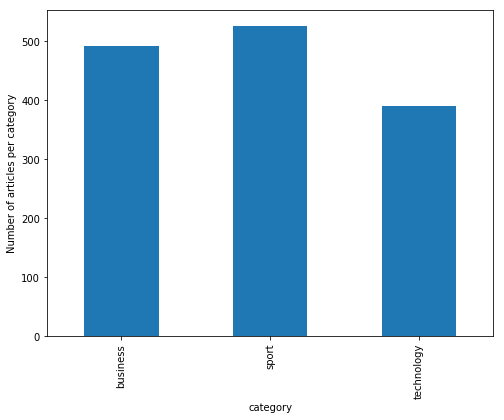

In [14]:
# Plot for visual representation of the number of articles per category in the corpus

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').content.count().plot.bar(ylim=0)
plt.ylabel('Number of articles per category')
plt.show()

<h5> The need to pre-process raw data </h5>

Raw text documents are unstructured. In analysing this type of data is to split all the words of the text data into individual "tokens", where each token corresponds to a single term(word). 

However, raw data cannot be directly analysed for classification and learning processes because we have to deal with a few problems that come with any language. For our case, with language, English, we have the following problems:
<ol>
<li>  Minimum term length: Since a lot of the prepositions and most frequent words are either 1 or 2 alphabets long, we wish to ignore them. </li>
<li> Case conversion: To make further processing easier, it is beneficial to convert all the terms of the corpus to lower-case only.</li>
<li> Stemming: Process by which endings are removed from terms. </li>
<li> Lemmatisation: Process to reduce a term to its canonical form. Both lemmatization and stemming help by ensuring that the inflected or canonical forms of any word aren't categorised as different words later when they are converted to tokens. We can simply use lemmatization instead of both stemming and lemmatization, since lemmatization takes care of the funcitonality of stemming. </li>
<li> Stop-word filtering: Filter out the words which appear frequently, but are of no help in decision making, eg: are, while etc.</li>
<li> Low frequency filtering: Remove terms that appear in very few documents. </li>
</ol>

For our corpus we use the packages scikit and nltk and work with lemmatization for dealing with all the problems mentioned above.

In [15]:
import nltk
nltk.download('wordnet')
import numpy as np
import matplotlib.cm as cm
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radhika\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h4> Pre-processing steps: Tokenization, Lemmatization and creation of  the TF_IDF matrix</h4>

Performing the preprocessing steps and creation of the TF_IDF matrix which gives weights to the words which show the imporance of the words for a document. This is done to ensure that words that are in abundance but irrelevant to decision making don't overshadow the important words needed for decision making.

In [16]:
import string

def lemma_tokenizer(text):
    
    for p in string.punctuation:
        text = text.replace(p, " ")
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

In [17]:
# we can pass in the same preprocessing parameters
term_weight = TfidfVectorizer(stop_words="english",min_df=5,tokenizer=lemma_tokenizer)
weights = term_weight.fit_transform(document)
# display some sample weighted values
print(weights.shape)
TF_IDVectorised = pd.DataFrame(weights.toarray(),columns = term_weight.get_feature_names())
#TF_IDVectorised.head()

(1408, 6101)


In [18]:
# Add a column to include the category of the article for which the word has appeared
# add a column to display the link of the article in which the word appeared
TF_IDVectorised['CLASS'] = df['category']
TF_IDVectorised['FILE'] = df['name']

In [19]:
TF_IDVectorised = TF_IDVectorised.set_index('FILE')

In [20]:
TF_IDVectorised.shape
TF_IDVectorised.head()

,000,000m,01,03,04,05,07,10,100,100m,...,yukos,zealand,zero,zidane,zinedine,zombie,zone,zoom,zurich,CLASS
FILE,,,,,,,,,,,,,,,,,,,,,
article-jan-0418.html,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,technology
article-jan-0027.html,0.051255,0.0,0.0,0.063967,0.0,0.0,0.061117,0.050779,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054892,business
article-jan-0631.html,0.026347,0.0,0.0,0.000000,0.0,0.0,0.000000,0.026103,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,technology
article-jan-2105.html,0.031093,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.043104,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,business
article-jan-3300.html,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.036287,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,sport


<h3> 2. Building the classification model</h3>

The data in the articles is now processed and can be used for classification and learning. We start by using classifier models to classify the articles. We will use the data from the previous steps and split it into training and test, where more data is used to train and a smaller portion is used to test. 

The first type of classifier I will be working with is:
<ul>
<li> K Nearest Neighbour Classifier </li>
</ul>

In [21]:
# working with data from TF_IDFVectorised for training and testing

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_KNN = TF_IDVectorised.iloc[:,1:6101]
Y_KNN = TF_IDVectorised.iloc[:,-1]

dataset_train, dataset_test, target_train, target_test = train_test_split(X_KNN, Y_KNN, test_size=0.2)
knn = KNN(n_neighbors=3)

print("Training set size is %d" % dataset_train.shape[0] )
print("Test set size is %d" % dataset_test.shape[0] )

Training set size is 1126
Test set size is 282


Using KNN = 5, since with this the highest accuracy was observed

In [22]:
model = KNN(n_neighbors=5)
model.fit(dataset_train, target_train)
print(model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


Use the accuracy metric to check the accuracy of the learning algorithm

In [51]:
# Make predictions to see how well is the learning process

predicted = model.predict(dataset_test)

from sklearn.metrics import accuracy_score
accuracy_scores= accuracy_score(target_test, predicted)
#print('The accuracy of K nearest neighbour is:',accuracy_scores)
#from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore,support = score(target_test, predicted)
print('The accuracy of K nearest neighbour is:',accuracy_scores)
#print('The accuracy of KNN is:', accuracy_scores)
print('The precision of KNN is: {}'.format(precision))
print('The recall of KNN is: {}'.format(recall))
print('The Fscore of KNN is: {}'.format(fscore))

The accuracy of K nearest neighbour is: 0.932624113475
The precision of KNN is: [ 0.96        0.94174757  0.88607595]
The recall of KNN is: [ 0.89719626  0.96039604  0.94594595]
The Fscore of KNN is: [ 0.92753623  0.95098039  0.91503268]


<hr style ="height:1px">
The second Classifier I will be working with is:
<ul>
<li> Naive Bayes Classifier  </li>
</ul>


In [25]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import MultinomialNB
# X -> features, y -> label

features = TF_IDVectorised.iloc[:,1:6101]
label = TF_IDVectorised.iloc[:,-1]
 
# dividing features, label into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state = 0)

Gaussian_NB = GaussianNB().fit(X_train, y_train)
Gaussian_NB_Predict = Gaussian_NB.predict(X_test)

In [26]:
# accuracy on X_test
accuracy = Gaussian_NB.score(X_test, y_test)
#print('The accuracy of the Naive Bayes classifier is:',accuracy)

In [27]:
Precision, Recall, Fscore, Support = score(y_test, Gaussian_NB_Predict)
print('The accuracy of Gaussian Naive Bayes is',accuracy)
print('The precision score of Gaussian Naive Bayes is: {}'.format(Precision))
print('The recall score of Gaussian Naive Bayes is: {}'.format(Recall))
print('The fscore of Gaussian Naive Bayes is: {}'.format(Fscore))


The accuracy of Gaussian Naive Bayes is 0.957386363636
The precision score of Gaussian Naive Bayes is: [ 0.98076923  0.98571429  0.89814815]
The recall score of Gaussian Naive Bayes is: [ 0.91071429  0.9787234   0.97979798]
The fscore of Gaussian Naive Bayes is: [ 0.94444444  0.98220641  0.93719807]


<h3> 3. Evaluation</h3>

Evaluation is used to compare the two classification models based on their performance metrics which are:
<ol>
    <li> Accuracy </li>
    <li> Precision </li>
    <li> Recall </li>
    <li> F1 -Scores </li>
</ol>

In the following section, we look at the evaluation metrics apart from accuracy for evaluating the classification models better. While accuracy is a good measure of how well a classifier has learn't, we cannot solely depend on it, as if the classes(features) are unbalanced, it might not be the best measure to look at. From the previous section, we see that the accuracy of the KNN classifier is 93% and Naive Bayes is roughly 95%

Precision and recall show the model's correct prediction based on relevent information, and it gives a good index of correct predictions( true positive) and false positive.

In [38]:
from sklearn.metrics import *
# Note that we indicate that we are interested in the Positive class here, which is labelled as "1"
knn_precision = precision_score(target_test, predicted, average='micro')
knn_recall = recall_score(target_test, predicted, average='micro')
knn_F1_score = f1_score(target_test, predicted, average='micro')
print('The Precision, Recall and F1 scores for KNN are:\n')
print("Precision (Positive) = %.2f" % knn_precision )
print("Recall (Positive) = %.2f" % knn_recall )
print("F1 (Positive) = %.2f" % knn_F1_score )

The Precision, Recall and F1 scores for KNN are:

Precision (Positive) = 0.93
Recall (Positive) = 0.93
F1 (Positive) = 0.93


In [39]:
print('The Precision and Recall scores for Naive Bayes are:\n')
nb_precision = precision_score(y_test, Gaussian_NB_Predict, average='micro')
nb_recall = recall_score(y_test, Gaussian_NB_Predict, average='micro')

print("Precision (Positive) = %.2f" % nb_precision )
print("Recall (Positive) = %.2f" % nb_recall )

The Precision and Recall scores for Naive Bayes are:

Precision (Positive) = 0.96
Recall (Positive) = 0.96


CONFUSION MATRIX
 
The confusion matrix is used to evaluate how correctly 

The confusion matrix for the given data using KNN classification is:
 
 [[96  3  8]
 [ 3 97  1]
 [ 1  3 70]]




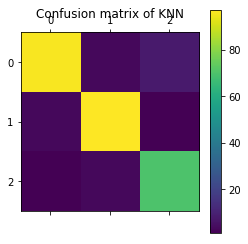

In [40]:
# build the confusion matrix for KNN classifier
import pylab as pl
confusion_mat = confusion_matrix(target_test, predicted)
print('The confusion matrix for the given data using KNN classification is:\n \n',confusion_mat)
print('\n')

pl.matshow(confusion_mat)
pl.title('Confusion matrix of KNN')
pl.colorbar()
pl.show()

For KNN, we see that we have a high level of accuracy when it comes to predictions for all the categories(correct predictions are given by green and yellow colour). and incorrect mapping(seen in purple/blue).

For Naive Bayes, the confusion matrix below shows how well has the classification model performed.



The confusion matrix of the data using Naive Bayes classification is: 
 [[102   0  10]
 [  2 138   1]
 [  0   2  97]]


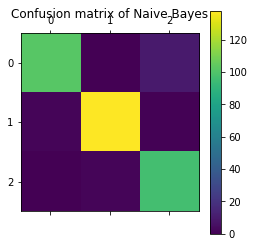

In [41]:
# build the confusion matrix for Naive Bayes Classifier 
NB_Confusion_Matrix = confusion_matrix(y_test, Gaussian_NB_Predict)

print('\n')
print('The confusion matrix of the data using Naive Bayes classification is: \n',NB_Confusion_Matrix)
pl.matshow(NB_Confusion_Matrix)
pl.title('Confusion matrix of Naive Bayes')
pl.colorbar()
pl.show()

CROSS VALIDATION

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 

By using cross validation, we keep overfitting in check.

In [42]:
# Getting the mean score accross all the cross validation
from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(model, X_KNN, Y_KNN, cv=10, scoring="accuracy")
print("KNN: Mean cross-validation accuracy = %.2f" % acc_scores.mean() )

Naive_bayes_accuracy_score = cross_val_score(Gaussian_NB, features, label, cv=10, scoring="accuracy")
print("Naive Bayes: Mean cross-validation accuracy = %.2f" % acc_scores.mean() )

KNN: Mean cross-validation accuracy = 0.96
Naive Bayes: Mean cross-validation accuracy = 0.96


Cross Validation ensures that the choice of test and training data does not hamper the model's ability to correctly predict. The average score for both models shows that by performing cross validation, the average accuracy for Naive Bayes improves, and that for KNN decreases. 

This is why cross validation is a good measure to supress over-fitting.

In [52]:
Scores_KNN = [accuracy_scores,knn_precision,knn_recall]
Scores_NB = [accuracy,nb_precision,nb_recall]


In [53]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
#import plotly.plotly as py
measure =['Accuracy', 'Precision','Recall']
Scores_KNN = [accuracy_scores,knn_precision,knn_recall]
Scores_NB = [accuracy,nb_precision,nb_recall]
scores = pd.DataFrame(
    {'Measure':measure,
     'KNN': Scores_KNN,
     'Naive Bayes': Scores_NB,
    })

scores= scores.set_index('Measure')

In [54]:
scores

,KNN,Naive Bayes
Measure,,
Accuracy,0.932624,0.957386
Precision,0.932624,0.957386
Recall,0.932624,0.957386


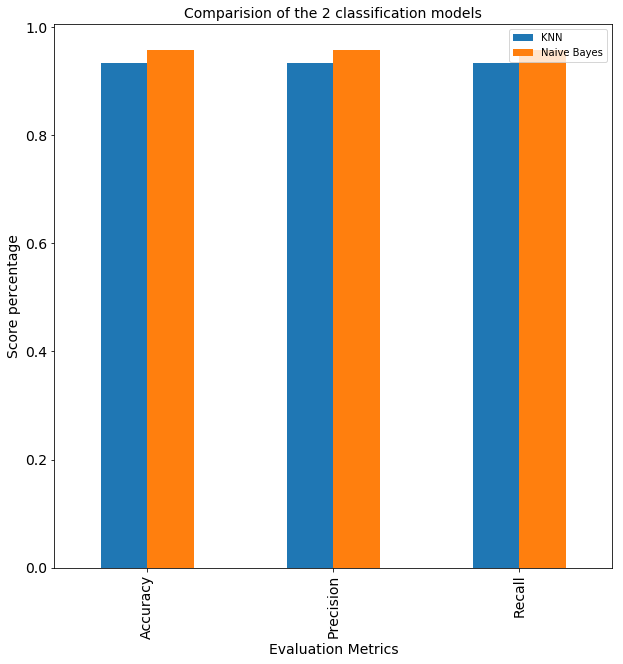

In [55]:
p = scores.plot.bar(figsize=(10,10),fontsize=14)
p.set_xlabel("Evaluation Metrics",fontsize=14)
p.set_ylabel("Score percentage",fontsize=14)
p.set_title("Comparision of the 2 classification models",fontsize=14)
#p = scores.plot.bar()
plt.show()

From the graph above, we can see that for the given Data, in terms of Precision, recall and accuracy, the performance of Naive Bayes classifier is better than KNN for our data. 
KNN is better for a smaller dataset, but doesn't work that well with large dataset. It also doesn't take into consideration which attributes are more important than the others.

Which is why, for our data, Naive-Bayes is a better classificaiton model.


In [56]:
from sklearn.metrics import classification_report

print('The Summarised classification report for KNN is:')
print(classification_report(target_test, predicted))


The Summarised classification report for KNN is:
             precision    recall  f1-score   support

   business       0.96      0.90      0.93       107
      sport       0.94      0.96      0.95       101
 technology       0.89      0.95      0.92        74

avg / total       0.93      0.93      0.93       282



In [57]:
print('The Summarised classification report for Naive Bayes is:')
print(classification_report(y_test, Gaussian_NB_Predict))

The Summarised classification report for Naive Bayes is:
             precision    recall  f1-score   support

   business       0.98      0.91      0.94       112
      sport       0.99      0.98      0.98       141
 technology       0.90      0.98      0.94        99

avg / total       0.96      0.96      0.96       352



The summarised classification report of both the models show the performance metrics of each classification model and how they performed for each of the categories.  

<hr style ='height:2px'>
